In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')




Saving cleaned_credit.csv to cleaned_credit (1).csv
User uploaded file "cleaned_credit (1).csv" with length 7221280 bytes


In [5]:
df = pd.read_csv("cleaned_credit.csv")

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (149986, 11)


,default,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [7]:
default_rate = df["default"].mean()
print(f"Overall Default Rate: {default_rate:.2%}")


Overall Default Rate: 6.68%


In [8]:
df["income_bucket"] = pd.qcut(
    df["MonthlyIncome"],
    q=5,
    duplicates="drop"
)


/tmp/ipython-input-2256879319.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_default = df.groupby("income_bucket")["default"].mean()


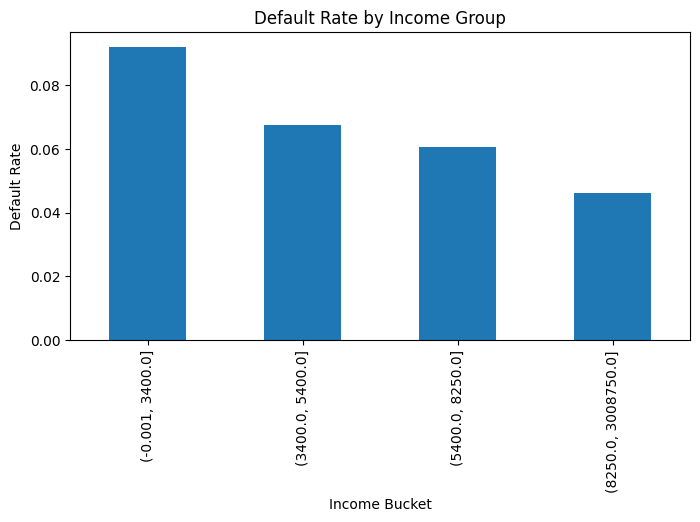

In [9]:
income_default = df.groupby("income_bucket")["default"].mean()

income_default.plot(kind="bar", figsize=(8,4))
plt.title("Default Rate by Income Group")
plt.ylabel("Default Rate")
plt.xlabel("Income Bucket")
plt.show()


In [10]:
df["income_bucket"] = pd.qcut(
    df["MonthlyIncome"],
    q=5,
    duplicates="drop"
)



/tmp/ipython-input-2256879319.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_default = df.groupby("income_bucket")["default"].mean()


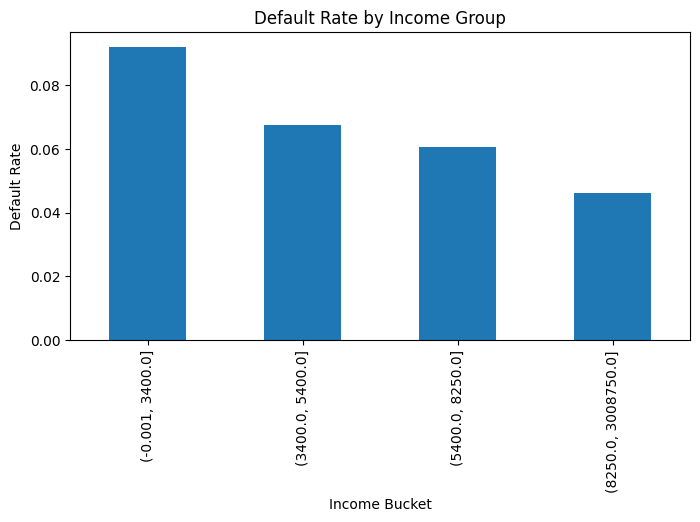

In [11]:
income_default = df.groupby("income_bucket")["default"].mean()

income_default.plot(kind="bar", figsize=(8,4))
plt.title("Default Rate by Income Group")
plt.ylabel("Default Rate")
plt.xlabel("Income Bucket")
plt.show()


/tmp/ipython-input-1021501581.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  debt_default = df.groupby("debt_bucket")["default"].mean()


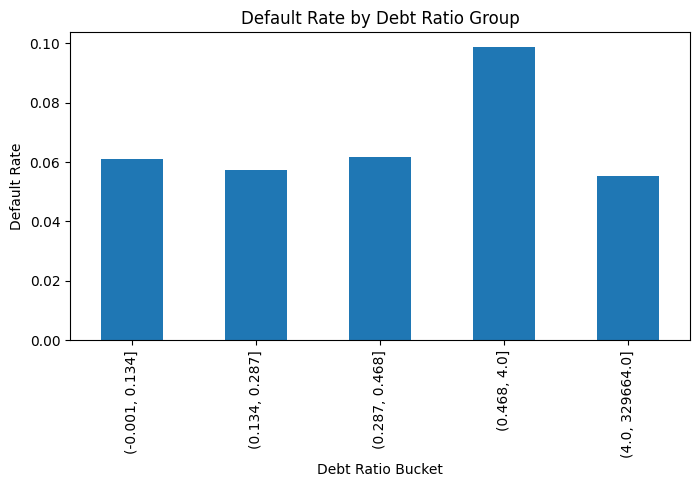

In [12]:
df["debt_bucket"] = pd.qcut(
    df["DebtRatio"],
    q=5,
    duplicates="drop"
)

debt_default = df.groupby("debt_bucket")["default"].mean()

debt_default.plot(kind="bar", figsize=(8,4))
plt.title("Default Rate by Debt Ratio Group")
plt.ylabel("Default Rate")
plt.xlabel("Debt Ratio Bucket")
plt.show()


In [13]:
df["any_past_due"] = (
    (df["NumberOfTime30-59DaysPastDueNotWorse"] > 0) |
    (df["NumberOfTime60-89DaysPastDueNotWorse"] > 0) |
    (df["NumberOfTimes90DaysLate"] > 0)
)

df.groupby("any_past_due")["default"].mean()


,default
any_past_due,
False,0.027285
True,0.222687


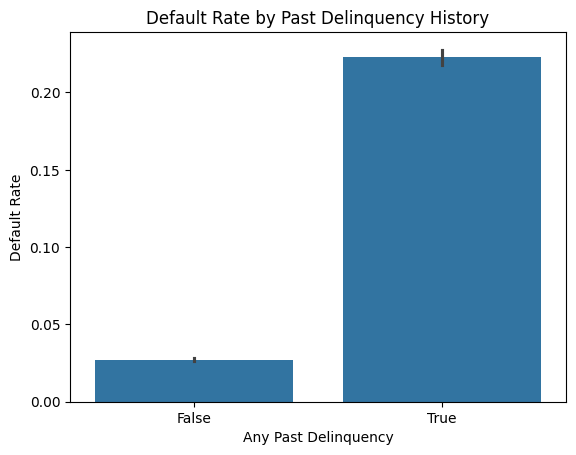

In [14]:
import seaborn as sns

sns.barplot(x="any_past_due", y="default", data=df)
plt.title("Default Rate by Past Delinquency History")
plt.xlabel("Any Past Delinquency")
plt.ylabel("Default Rate")
plt.show()


/tmp/ipython-input-659090532.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_default = df.groupby("age_bucket")["default"].mean()


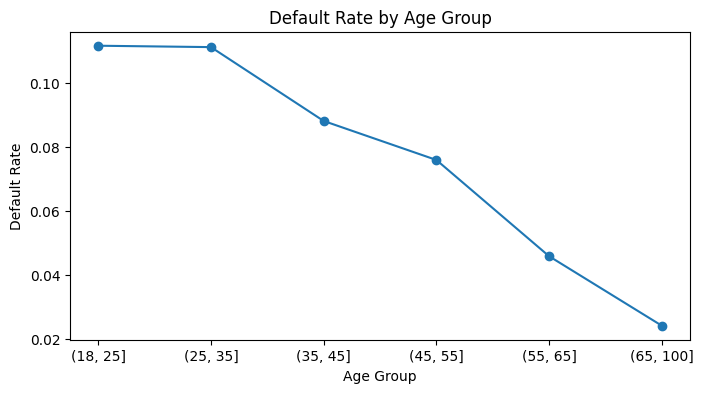

In [15]:
df["age_bucket"] = pd.cut(
    df["age"],
    bins=[18,25,35,45,55,65,100]
)

age_default = df.groupby("age_bucket")["default"].mean()

age_default.plot(kind="line", marker="o", figsize=(8,4))
plt.title("Default Rate by Age Group")
plt.ylabel("Default Rate")
plt.xlabel("Age Group")
plt.show()


## Summary of Exploratory Findings

- Default risk is higher among low-income and high-debt borrowers
- Past delinquency history is the strongest predictor of default
- Credit risk varies non-linearly across age groups
- These findings are consistent with real-world lending intuition and guide model design


# Credit Risk Modeling

## Objective
The objective of this notebook is to build an interpretable credit risk model to estimate the probability of borrower default.

The focus is on:
- Predicting default probability
- Using explainable models suitable for banking and fintech applications
- Evaluating model performance using risk-appropriate metrics

Logistic regression is used as the baseline model due to its interpretability and widespread use in credit risk analytics.


In [16]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt

df = pd.read_csv("cleaned_credit.csv")

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (149986, 11)


,default,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [17]:
X = df.drop("default", axis=1)
y = df["default"]


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [19]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [20]:
model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"  # handles class imbalance
)

model.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [21]:
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]


In [22]:
auc = roc_auc_score(y_test, y_pred_prob)
print("ROC–AUC Score:", round(auc, 4))


ROC–AUC Score: 0.8271


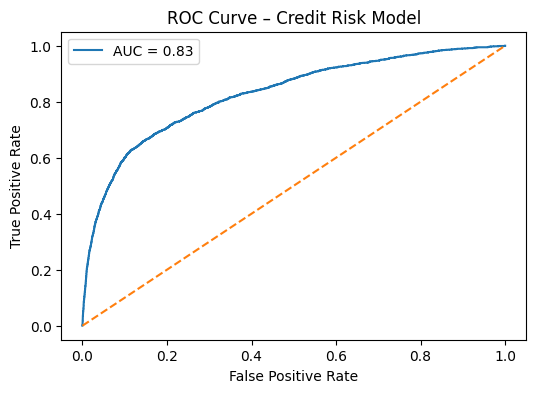

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Credit Risk Model")
plt.legend()
plt.show()


In [24]:
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

coefficients


,Feature,Coefficient
6,NumberOfTimes90DaysLate,0.724934
2,NumberOfTime30-59DaysPastDueNotWorse,0.567383
8,NumberOfTime60-89DaysPastDueNotWorse,0.496388
7,NumberRealEstateLoansOrLines,0.104022
9,NumberOfDependents,0.048905
5,NumberOfOpenCreditLinesAndLoans,0.047123
0,RevolvingUtilizationOfUnsecuredLines,-0.001027
3,DebtRatio,-0.107914
4,MonthlyIncome,-0.212558
1,age,-0.442642


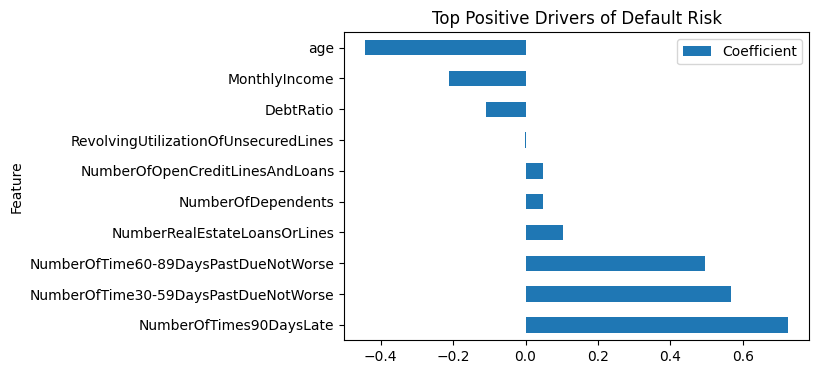

In [25]:
coefficients.head(10).plot(
    x="Feature",
    y="Coefficient",
    kind="barh",
    figsize=(6,4),
    title="Top Positive Drivers of Default Risk"
)
plt.show()


## Model Interpretation and Business Insights

- Past delinquency variables have the strongest positive relationship with default risk
- Higher debt ratios and credit utilization increase default probability
- Income and stable demographic factors reduce credit risk

The model prioritizes interpretability and aligns closely with how banks and fintech lenders evaluate credit risk in practice.


# Credit Decision Framework

## Objective
The objective of this notebook is to convert predicted default probabilities into
practical lending decisions.

This step bridges the gap between predictive modeling and real-world fintech lending
by introducing:
- Risk-based approval thresholds
- Explainable credit decisions
- Risk-adjusted loan pricing

These components reflect how credit risk models are operationalized in practice.


In [26]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

df = pd.read_csv("cleaned_credit.csv")

X = df.drop("default", axis=1)
y = df["default"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_train_scaled, y_train)

y_test_prob = model.predict_proba(X_test_scaled)[:, 1]

results = X_test.copy()
results["default_prob"] = y_test_prob
results["actual_default"] = y_test.values

results.head()


,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,default_prob,actual_default
92222,0.117364,63,0,0.431251,5970.0,7,0,2,0,0.0,0.255890,0
146786,0.737316,50,1,0.216323,7816.0,5,0,1,0,2.0,0.490928,1
76044,0.451655,56,0,0.346449,5336.0,11,0,1,0,3.0,0.316890,0
117631,0.158179,52,0,0.286857,6626.0,6,0,1,0,0.0,0.299045,0
21982,0.892104,34,0,0.525619,4000.0,6,1,0,0,0.0,0.684301,0


In [27]:
def credit_decision(prob):
    if prob < 0.10:
        return "Approve"
    elif prob < 0.25:
        return "Review"
    else:
        return "Reject"

results["decision"] = results["default_prob"].apply(credit_decision)

results["decision"].value_counts(normalize=True)


,proportion
decision,
Reject,0.753550
Review,0.244383
Approve,0.002067


In [28]:
coefficients = pd.Series(
    model.coef_[0],
    index=X.columns
).sort_values(ascending=False)

coefficients.head(10)


,0
NumberOfTimes90DaysLate,0.724934
NumberOfTime30-59DaysPastDueNotWorse,0.567383
NumberOfTime60-89DaysPastDueNotWorse,0.496388
NumberRealEstateLoansOrLines,0.104022
NumberOfDependents,0.048905
NumberOfOpenCreditLinesAndLoans,0.047123
RevolvingUtilizationOfUnsecuredLines,-0.001027
DebtRatio,-0.107914
MonthlyIncome,-0.212558
age,-0.442642


In [29]:
def explain_borrower(row, coef, top_n=3):
    contributions = row * coef
    return contributions.sort_values(ascending=False).head(top_n)

sample_borrower = results.iloc[0][X.columns]
explain_borrower(sample_borrower, coefficients)


,0
NumberOfOpenCreditLinesAndLoans,0.329862
NumberRealEstateLoansOrLines,0.208044
NumberOfDependents,0.0


In [30]:
def risk_based_interest(prob):
    if prob < 0.10:
        return 0.12   # 12%
    elif prob < 0.25:
        return 0.18   # 18%
    else:
        return 0.25   # 25%

results["interest_rate"] = results["default_prob"].apply(risk_based_interest)

results[["default_prob", "decision", "interest_rate"]].head()


,default_prob,decision,interest_rate
92222,0.255890,Reject,0.25
146786,0.490928,Reject,0.25
76044,0.316890,Reject,0.25
117631,0.299045,Reject,0.25
21982,0.684301,Reject,0.25


In [31]:
results.groupby("decision")["actual_default"].mean()


,actual_default
decision,
Approve,0.032258
Reject,0.084981
Review,0.011185


## Key Takeaways

- Credit risk models must translate probabilities into business decisions
- Risk thresholds help balance growth and default risk
- Explainability is critical for regulatory compliance
- Risk-based pricing aligns return with borrower risk

This framework closely mirrors how fintech lenders operationalize credit risk models.

In [32]:
import joblib

joblib.dump(model, "credit_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']